In [1]:
import os
import glob as glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
import os
from nltools.mask import expand_mask, roi_to_brain
from nltools.data import Brain_Data, Adjacency
from tqdm.notebook import tqdm

In [2]:
base_dir = '/Volumes/Shaolin/modernmedia_menghan/'
behavior = ['3_ResearchDataSet','4_Prestudy Survey Data']
behavior_file = glob.glob(os.path.join(base_dir,behavior[0],'*.csv'))
behavior_file

['/Volumes/Shaolin/modernmedia_menghan/3_ResearchDataSet/kamm_data_2023-11-01_1026.csv']

In [59]:
behavior_all = pd.read_csv(behavior_file[0])
pmu_cols = [col for col in behavior_all.columns if 'pmu_' in col]
print(pmu_cols)

['pmu_self_1', 'pmu_self_2', 'pmu_self_3', 'pmu_self_4', 'pmu_self_5', 'pmu_self_6', 'pmu_self_7', 'pmu_self_8', 'pmu_self_9', 'pmu_self_10', 'pmu_self_11']


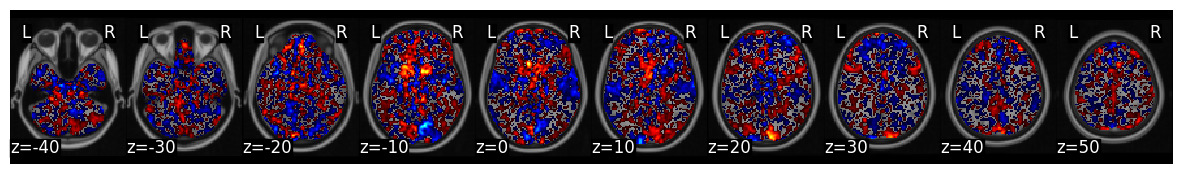

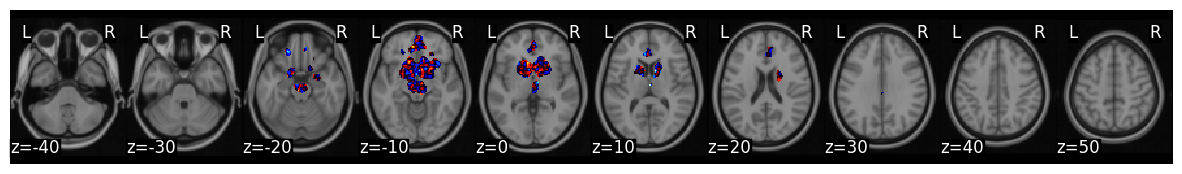

In [9]:
rewardssignature_path = '/Volumes/Shaolin/toolboxes_menghan/material/masks/rewardssignature'
rewardssignature = Brain_Data(os.path.join(rewardssignature_path,'SVM_HCP_Reward_vs_Punish_n392_zscore1_smooth0_weightmap.nii.gz'))
rewardssignature.plot()

rewardssignature_masked = Brain_Data(os.path.join(rewardssignature_path,'SVM_HCP_Reward_vs_Punish_n392_masked_zscore1_smooth0_weightmap.nii.gz'))
rewardssignature_masked.plot()
                              

## Participants that have both neural and behavioral data


In [10]:
condition = ['Household','MobileDevice','MediaLogo','Food','NeutralLogo']
group_file_list = glob.glob(os.path.join(base_dir,'denoised','smoothed','beta',f'sub*{condition[0]}*.nii.gz'))
sub_name_all_neural = []
for i in group_file_list:
    a = i.split('/')[-1]
    m = a.split('_')[0]
    sub_name_all_neural.append(m)
len(sub_name_all_neural)

SID_list_neural = []
for SID in sub_name_all_neural:
    # print(SID)
    SID_list_neural.append(SID[-6:])

In [11]:
sub_name_all_behavior = behavior_all['mri_sid_number'].values.tolist()
SID_list_behavior = []
for SID in sub_name_all_behavior:
    # print(SID)
    SID_list_behavior.append(SID[-6:])

TypeError: 'float' object is not subscriptable

In [15]:
sub_name_all = [item for item in SID_list_behavior if item in SID_list_neural]
print(len(sub_name_all))

34


In [16]:
sub_name_all_behavior_similarity = ['SID' + item for item in sub_name_all]
sub_name_all_neural_similarity = ['sub-sid' + item for item in sub_name_all]

In [49]:
reward_subj_condition = []
reward_subj_condition_masked = []
for subject in sub_name_all_neural_similarity:
    reward_subj = []
    reward_subj_masked = []
    for condition_label in condition:
        subject_neural = Brain_Data(glob.glob(os.path.join(base_dir,'denoised','unsmoothed','beta',f'{subject}*{condition_label}*.nii.gz')))
        corr = subject_neural.similarity(rewardssignature)
        corr_masked = subject_neural.similarity(rewardssignature_masked)
        
        reward_subj.append(corr.tolist())
        reward_subj_masked.append(corr_masked.tolist())

    reward_subj_condition.append(reward_subj)
    reward_subj_condition_masked.append(reward_subj_masked)


In [50]:
reward_subj_condition_df = pd.DataFrame(reward_subj_condition)
reward_subj_condition_masked_df = pd.DataFrame(reward_subj_condition_masked)


/var/folders/74/dlpfdyk15p5317gf04vkydgm0000gt/T/ipykernel_20393/4192605946.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(condition)


Text(0.5, 1.0, 'Reward  (unmasked)')

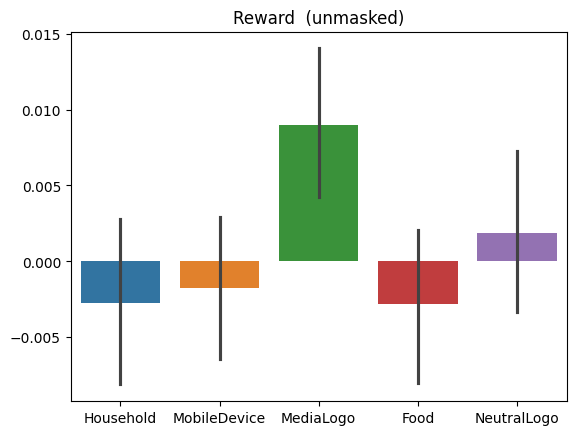

In [55]:
ax = sns.barplot(reward_subj_condition_df)
ax.set_xticklabels(condition)
plt.title("Reward  (unmasked)")

/var/folders/74/dlpfdyk15p5317gf04vkydgm0000gt/T/ipykernel_20393/2554125557.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(condition)


Text(0.5, 1.0, 'Reward  (Masked)')

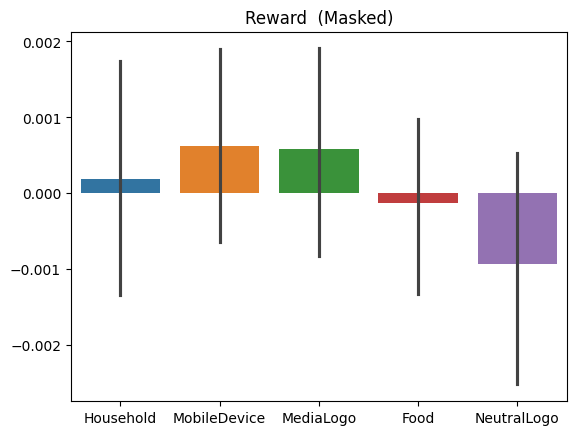

In [56]:
ax = sns.barplot(reward_subj_condition_masked_df)
ax.set_xticklabels(condition)
plt.title("Reward  (Masked)")

In [64]:
partitipants_behavior_df = behavior_all[behavior_all['mri_sid_number'].isin(sub_name_all_behavior_similarity)]
partitipants_behavior_df_pmu = partitipants_behavior_df[pmu_cols]
partitipants_behavior_df_pmu_screener = pd.DataFrame(partitipants_behavior_df['pmu'])

In [72]:
partitipants_behavior_df_pmu_mean = pd.DataFrame(partitipants_behavior_df_pmu.mean(axis=1))

Text(0, 0.5, 'child pmu (averaged)')

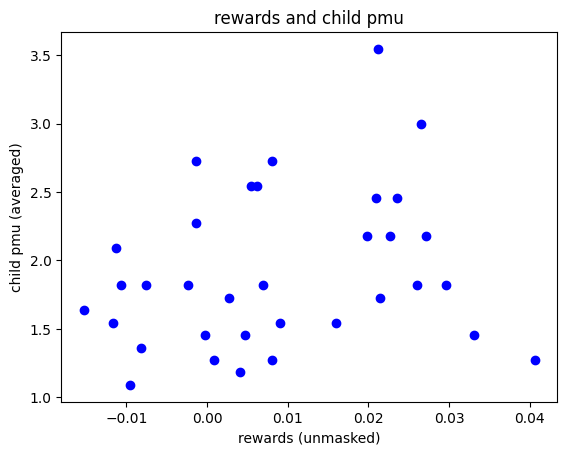

In [82]:
 
plt.plot(pd.DataFrame(reward_subj_condition_df.iloc[:,2]),partitipants_behavior_df_pmu_mean, 'o',color='b')
plt.title("rewards and child pmu")
plt.xlabel("rewards (unmasked)")
plt.ylabel("child pmu (averaged)")


In [206]:
from scipy import stats

stats.pearsonr(reward_subj_condition_df.iloc[:,2].tolist(), partitipants_behavior_df_pmu_mean[0].tolist())


PearsonRResult(statistic=0.22952577326063017, pvalue=0.19161801796857778)

In [112]:
import pingouin as pg
data = pd.DataFrame(np.array([reward_subj_condition_df.iloc[:,2],partitipants_behavior_df_pmu_mean[0]]).T)
pg.linear_regression(data.iloc[:,0],data.iloc[:,1],add_intercept = True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.842679,0.114355,16.113623,6.520543e-17,0.052682,0.023078,1.609744,2.075613
1,0,8.890221,6.664292,1.334008,1.916180e-01,0.052682,0.023078,-4.684497,22.464939


Text(0, 0.5, 'child pmu (averaged)')

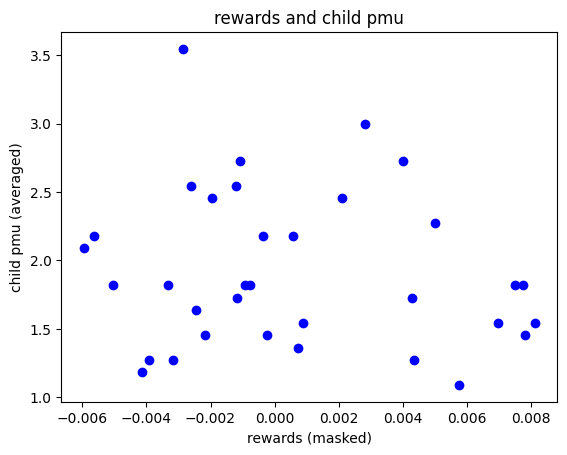

In [81]:

 
plt.plot(pd.DataFrame(reward_subj_condition_masked_df.iloc[:,2]),partitipants_behavior_df_pmu_mean, 'o',color='b')
plt.title("rewards and child pmu")
plt.xlabel("rewards (masked)")
plt.ylabel("child pmu (averaged)")


In [207]:

stats.pearsonr(reward_subj_condition_masked_df.iloc[:,2].tolist(), partitipants_behavior_df_pmu_mean[0].tolist())

PearsonRResult(statistic=-0.14466307221023594, pvalue=0.4143406085700006)

In [116]:

data = pd.DataFrame(np.array([reward_subj_condition_masked_df.iloc[:,2],partitipants_behavior_df_pmu_mean[0]]).T)
pg.linear_regression(data.iloc[:,0],data.iloc[:,1],add_intercept = True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.933917,0.100054,19.328744,3.277611e-19,0.020927,-0.009669,1.730114,2.137721
1,0,-19.695701,23.814760,-0.827038,4.143406e-01,0.020927,-0.009669,-68.204781,28.813379


Text(0, 0.5, 'child pmu (prescreened)')

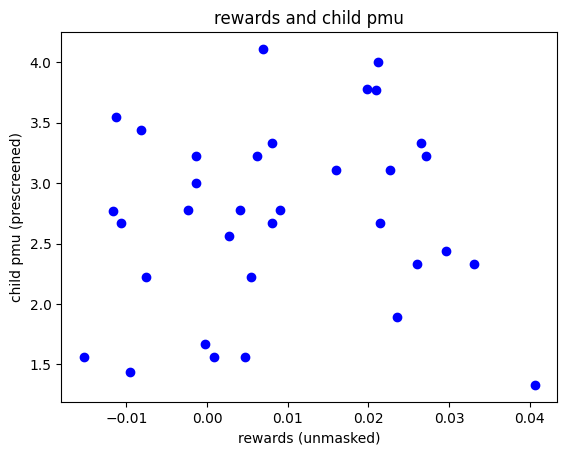

In [83]:
 
plt.plot(pd.DataFrame(reward_subj_condition_df.iloc[:,2]),partitipants_behavior_df_pmu_screener, 'o',color='b')
plt.title("rewards and child pmu")
plt.xlabel("rewards (unmasked)")
plt.ylabel("child pmu (prescreened)")


In [208]:

stats.pearsonr(reward_subj_condition_df.iloc[:,2].tolist(), partitipants_behavior_df_pmu_screener['pmu'].tolist())

PearsonRResult(statistic=0.08775046688434414, pvalue=0.6216707058401034)

In [120]:

data = pd.DataFrame(np.array([reward_subj_condition_df.iloc[:,2],partitipants_behavior_df_pmu_screener['pmu']]).T)
pg.linear_regression(data.iloc[:,0],data.iloc[:,1],add_intercept = True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2.677766,0.155288,17.243923,9.260166e-18,0.0077,-0.023309,2.361456,2.994076
1,0,4.509591,9.049699,0.498314,6.216707e-01,0.0077,-0.023309,-13.924044,22.943225


Text(0, 0.5, 'child pmu (prescreened)')

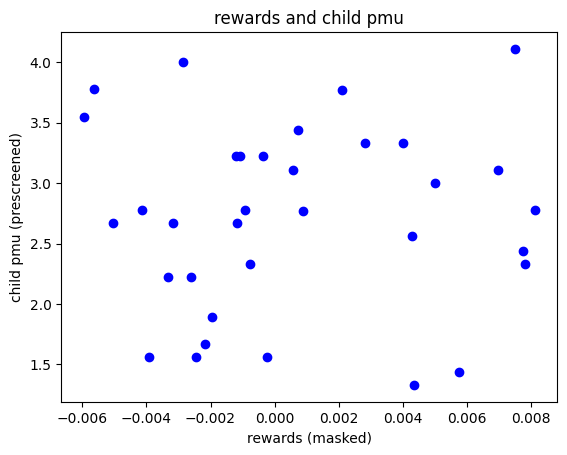

In [84]:
 
plt.plot(pd.DataFrame(reward_subj_condition_masked_df.iloc[:,2]),partitipants_behavior_df_pmu_screener, 'o',color='b')
plt.title("rewards and child pmu")
plt.xlabel("rewards (masked)")
plt.ylabel("child pmu (prescreened)")


In [209]:
stats.pearsonr(reward_subj_condition_masked_df.iloc[:,2].tolist(), partitipants_behavior_df_pmu_screener['pmu'].tolist())

PearsonRResult(statistic=0.01790687204154826, pvalue=0.919934302650568)

In [210]:

data = pd.DataFrame(np.array([reward_subj_condition_masked_df.iloc[:,2],partitipants_behavior_df_pmu_screener['pmu']]).T)
pg.linear_regression(data.iloc[:,0],data.iloc[:,1],add_intercept = True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2.716354,0.134142,20.249884,8.242010e-20,0.000321,-0.030919,2.443116,2.989591
1,0,3.234745,31.928293,0.101313,9.199343e-01,0.000321,-0.030919,-61.801060,68.270551
